In [1]:
# !pip3 install pandas seaborn 
# !pip3 install statsmodels openpyxl

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from scipy.stats import norm
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt;
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error as mse
import itertools
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
plt.rcdefaults()
import warnings
warnings.filterwarnings('ignore')

In [13]:
df_uah1 = pd.read_excel("/Users/Marta/Desktop/diploma/Data_1_S.xlsx", "quantity",engine='openpyxl')
df_uah1 = df_uah1.set_index(["Period"])
df_uah1["Total 1"] = df_uah1["T1"] +df_uah1["T2"] +df_uah1["T3"] +df_uah1["T4"]
df_uah1["Total 2"] = df_uah1[[c for c in df_uah1.columns if "P" in c]].sum(axis=1)
df_uah1["Total"] = df_uah1["Total 1"] + df_uah1["Total 2"]
test_len = 0.15
df_uah2 = df_uah1.iloc[:int(len(df_uah1)*(1-test_len))]

In [4]:
result = seasonal_decompose(df_uah1["T2"], model='additive',extrapolate_trend='freq')

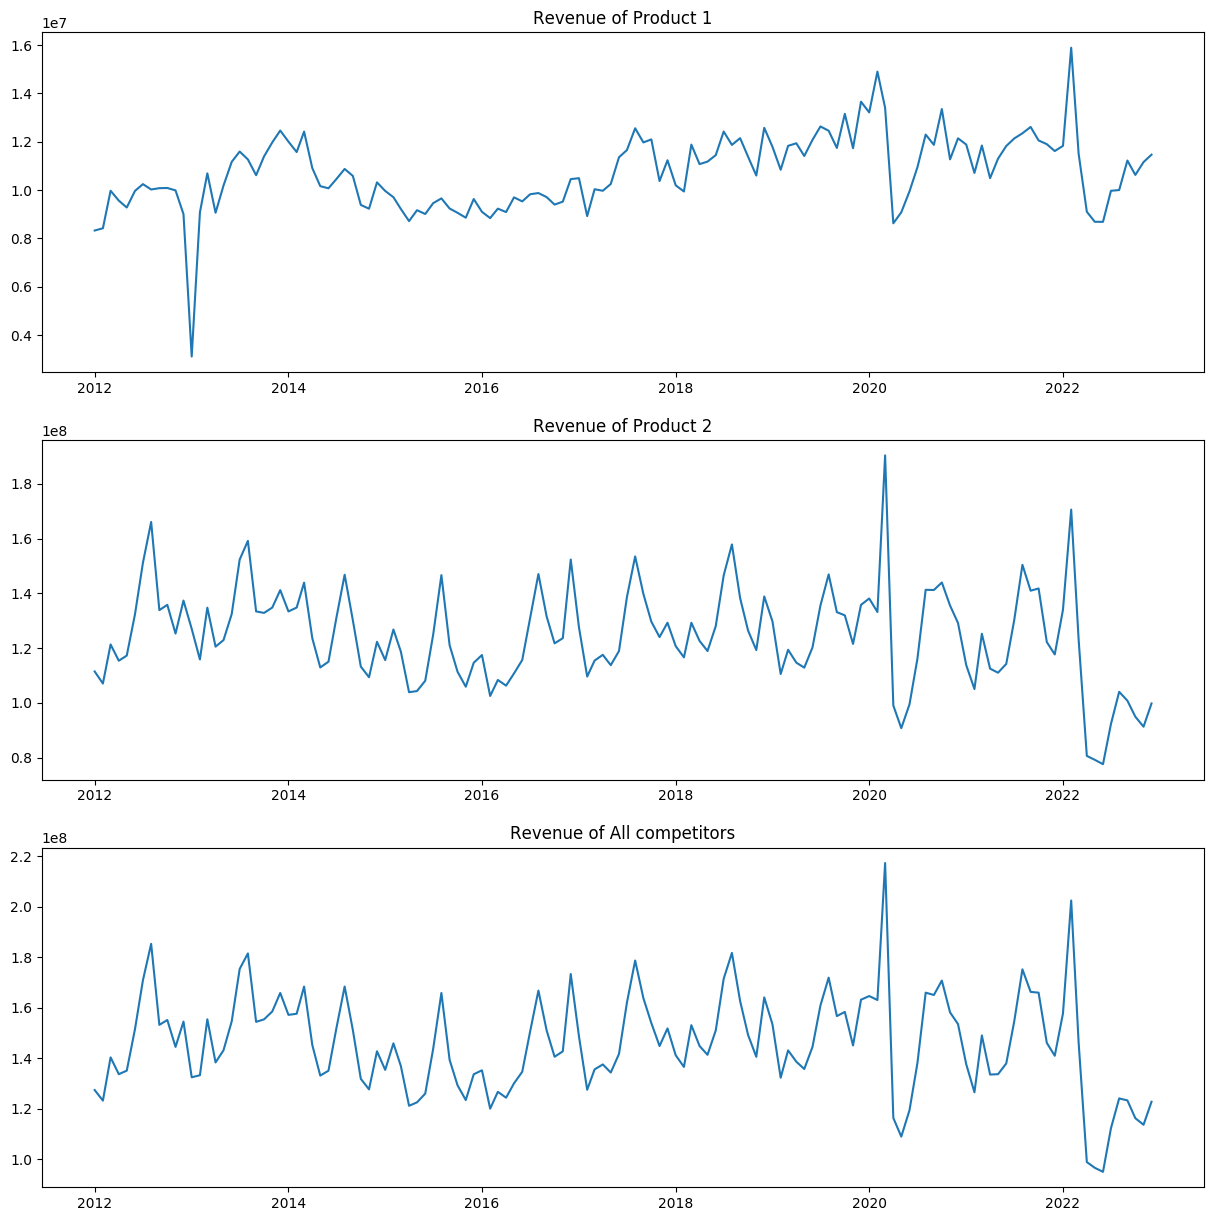

In [5]:
figure, axis = plt.subplots(3, 1, figsize=(15, 15))
  
# For Sine Function
axis[0].plot(df_uah1["T1"].index, df_uah1["T1"])
axis[0].set_title("Revenue of Product 1")
  
axis[1].plot(df_uah1["T2"].index, df_uah1["T2"])
axis[1].set_title("Revenue of Product 2")

axis[2].plot(df_uah1["Total 1"].index, df_uah1["Total 1"])
axis[2].set_title("Revenue of All competitors")
  
figure.show()

In [5]:
# df_uah1.index = pd.date_range(start='2019-01-01', end='2022-06-01', freq="MS")
# df_uah2.index = pd.date_range(start='2019-01-01', end='2021-12-01', freq="MS")


In [6]:
# see if the series is stationary with a derministic trend?

kpss(df_uah1["Total 1"])

(0.1401446662619501,
 0.1,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [8]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    print(dftest)
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')
check_stationarity(result.resid)

(-7.121974197165285, 3.7023676938690845e-10, 4, 127, {'1%': -3.482920063655088, '5%': -2.884580323367261, '10%': -2.5790575441750883}, 4151.726459508668)
The series is stationary


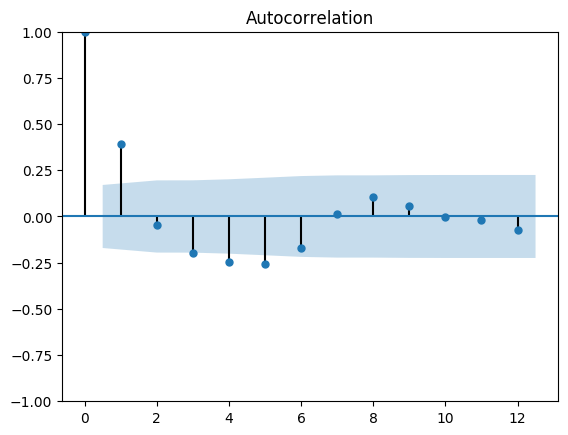

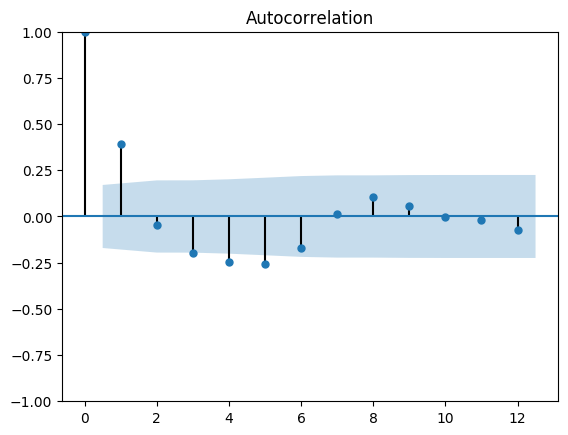

In [10]:
# analysing autocorrelation function 
plot_acf(result.resid, lags=12)

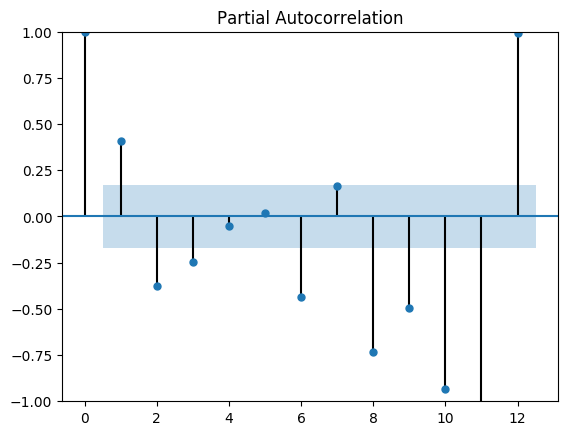

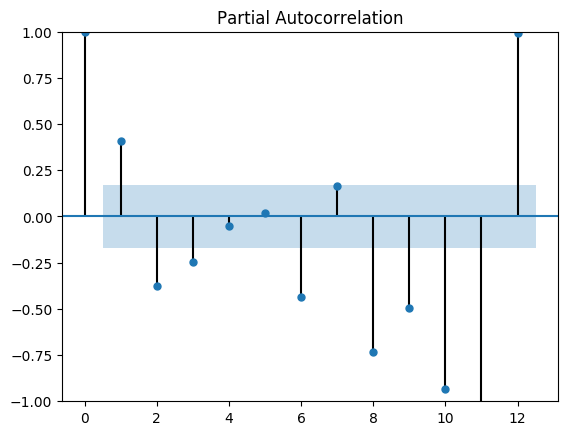

In [11]:
# analysing partial autocorrelation function 
plot_pacf(result.seasonal, lags=12)

In [17]:
m = SARIMAX(df_uah2["T1"], order=(12,0,3), seasonal_order=(12,0,3,16), type="additive", trend=(1,0,0)).fit()
preds = m.predict(start = 0, end= 67, dynamic=False)

Period
2012-01-01     8329455.28
2012-02-01     8422206.08
2012-03-01     9973766.42
2012-04-01     9565933.62
2012-05-01     9280618.84
                 ...     
2022-08-01    10002560.40
2022-09-01    11223629.10
2022-10-01    10628843.10
2022-11-01    11160301.30
2022-12-01    11465773.70
Name: T1, Length: 132, dtype: float64

<AxesSubplot:xlabel='Period'>

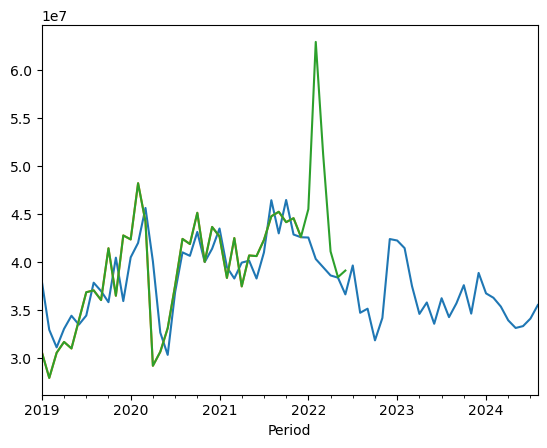

In [86]:
preds.plot()
df_uah2["T1"].plot()
df_uah1["T1"].plot()

In [ ]:
def check_kpss(ts):
    dftest = kpss(ts, regression="ct")
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[3]['5%']
    print(dftest)
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')
check_kpss(df_uah2["T1"])
check_kpss(df_uah2["T2"])
check_kpss(df_uah2["T3"])
check_kpss(df_uah2["T4"])

In [ ]:
scores = pd.DataFrame(index=["Series", "Order", 
                               "RMSE_train", "MAPE_train", "RMSE_test", "MAPE_test" , "r2", "cross-validation sample"])
p_s = range(0, 12)
q_s = range(0, 12)


In [18]:


i = 0

s="Total"
for p in p_s:
    for q in q_s:
        try:
            m = SARIMAX(df_uah2[s], 
                        order=(p,1,q), 
                        seasonal_order=(p,1,q,12), 
                        trend="c").fit(disp=False)
            preds = m.predict(start = 0, end= len(df_uah1), dynamic=False)
            preds[0] =preds[1]
            try:
                mse_train = np.sqrt(mse(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]]))
                mape_train = mape(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]])
                mse_test = np.sqrt(mse(df_uah1[s],preds.loc[df_uah1[s].index[0]:df_uah1[s].index[-1]]))
                mape_test = mape(df_uah1[s],preds.loc[df_uah1[s].index[0]:df_uah1[s].index[-1]])
                r2 = r2_score(df_uah1[s],preds.loc[df_uah1[s].index[0]:df_uah1[s].index[-1]])
                print(mse_train, mape_train, mse_test, mape_test, r2)
            except Exception as e:
                print(e)

            scores[i] = [s, f"({p}, 1, {q})", mse_train, mape_train, mse_test, mape_test, r2]
            i += 1
        except Exception as e:
            print(e, "error, moving on...")
scores.T.to_csv(f"/Users/Marta/Desktop/diploma/final_SARIMAX_{s}.csv")

33382069.882883627 0.07437868153119769 33382069.882883627 0.07437868153119769
2012-01-01    2.270296e+08
2012-02-01    2.270296e+08
2012-03-01    2.185951e+08
2012-04-01    2.480714e+08
2012-05-01    2.186037e+08
                  ...     
2024-09-01    1.714645e+08
2024-10-01    1.600023e+08
2024-11-01    1.458057e+08
2024-12-01    1.618601e+08
2025-01-01    1.588267e+08
Freq: MS, Name: predicted_mean, Length: 157, dtype: float64


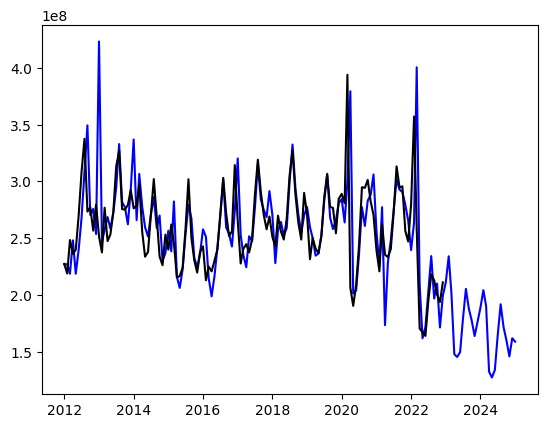

,0
Series,Total
Order,"(0, 1, 10)"
RMSE_train,3.33821e+07
MAPE_train,0.0743787
RMSE_test,3.33821e+07
MAPE_test,0.0743787
r2,0.152393
cross-validation sample,1


In [346]:
scores = pd.DataFrame(index=["Series", "Order", 
                               "RMSE_train", "MAPE_train", "RMSE_test", "MAPE_test" , "r2", "cross-validation sample"])

i=0
for cross_valid_period in [1]:
    
    
    df_uah2 = df_uah1.iloc[:int(len(df_uah1)*cross_valid_period)]
    if cross_valid_period == 0.6:
        full_period = df_uah1[s].index[94]
    else:
        full_period = df_uah1[s].index[-1]

    m = SARIMAX(df_uah2[s], 
                            order=((0,0,0,1),1,(0,0,0,1)), 
                            seasonal_order=((1,0,1,1),1,(1,0,1,1),12), 
                            trend="c").fit(disp=False)
    preds = m.predict(start = 0, end= len(df_uah1)+24, dynamic=False)
    preds[0] =preds[1]
    # try:
    mse_train = np.sqrt(mse(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]]))
    mape_train = mape(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]])
    mse_test = np.sqrt(mse(df_uah1[s].loc[df_uah1[s].index[0]:full_period],preds.loc[df_uah1[s].index[0]:full_period]))
    mape_test = mape(df_uah1[s].loc[df_uah1[s].index[0]:full_period],preds.loc[df_uah1[s].index[0]:full_period])
    r2 = r2_score(df_uah1[s].loc[df_uah1[s].index[0]:full_period],preds.loc[df_uah1[s].index[0]:full_period])
    print(mse_train, mape_train, mse_test, mape_test)
    print(preds)
    preds.to_csv("/Users/Marta/Desktop/diploma/sarimax_with_no_xs.csv")
    plt.plot(preds, color="blue")
    plt.plot(df_uah1[s], color="black")
    plt.show()
    
    scores[i] = [s, f"({p}, 1, {q})", mse_train, mape_train, mse_test, mape_test, r2, cross_valid_period]
    i += 1
scores

Total               mean       mean_se  mean_ci_lower  mean_ci_upper
2012-02-01  2.270296e+08  4.260171e+07   1.828758e+08   2.711835e+08
2012-03-01  2.185951e+08  4.260171e+07   1.744413e+08   2.627490e+08
2012-04-01  2.480714e+08  4.260171e+07   2.039175e+08   2.922252e+08
2012-05-01  2.186037e+08  4.247723e+07   1.745789e+08   2.626286e+08
2012-06-01  2.400406e+08  4.247723e+07   1.960158e+08   2.840654e+08


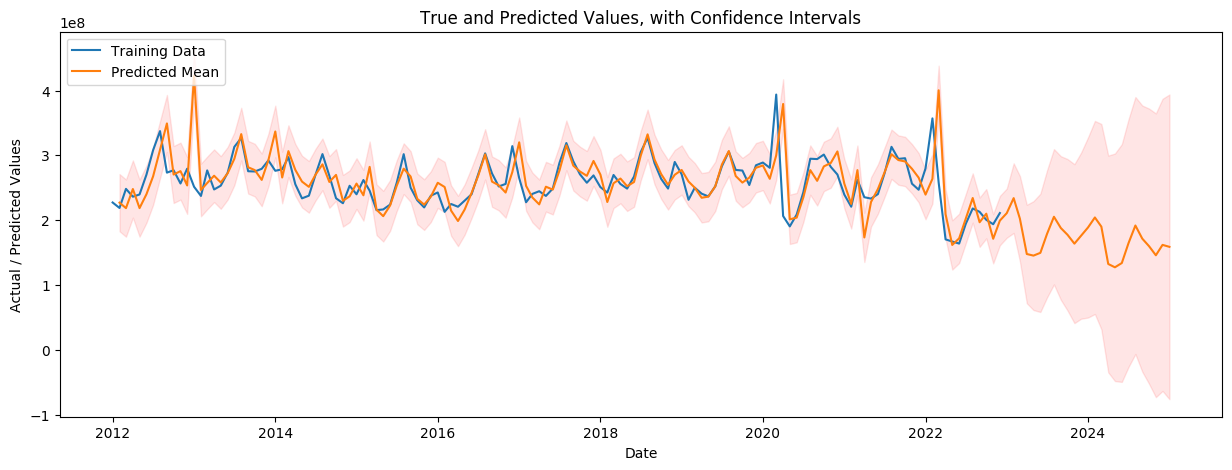

In [349]:
preds_df = (m
            .get_prediction(start=1, end=len(df_uah1)+24)
            .summary_frame(alpha=0.3)
)
print(preds_df.head())

ax.plot(df_uah1["Total"],label='Training Data')
ax.set(
    title='True and Predicted Values, with Confidence Intervals',
    xlabel='Date',
    ylabel='Actual / Predicted Values'
)
ax.plot(preds_df['mean'], label='Predicted Mean')
ax.fill_between(
    preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
    color='r', alpha=0.1
)
legend = ax.legend(loc='upper left')
plt.show()

In [302]:
projections = pd.read_csv("/Users/Marta/Desktop/diploma/SARIMAX/x_projections.csv")
projections["Average_price"] = projections["Average_price_CPI_adjusted_projected"]*projections["CPI_smoothed_predicted"]

,Unnamed: 0,Unnamed: 0.1,customer_pain1,customer_pain2,customer_pain3,customer_pain4,customer_pain5,customer_pain6,T1,T2,...,Population_smoothed,GDP_smoothed,CPI_smoothed,Average_price_CPI_adjusted,month,Average_price_CPI_adjusted_projected,Internet_access_smoothed_predicted,Population_smoothed_predicted,GDP_smoothed_predicted,CPI_smoothed_predicted
0,0,2012-01-01,38.857143,0.000000,60.285714,17.714286,2.142857,7.857143,8329455.28,1.114613e+08,...,4.535652e+07,4065.721693,99.621758,0.486408,1,0.5110,34.888948,4.550580e+07,4042.798190,101.641013
1,1,2012-02-01,30.000000,0.000000,34.857143,19.714286,9.285714,6.428571,8422206.08,1.070589e+08,...,4.550674e+07,3879.198521,100.972097,0.492270,2,0.5154,35.855106,4.526015e+07,3936.923796,97.683877
2,2,2012-03-01,44.714286,4.000000,27.285714,18.857143,6.428571,1.142857,9973766.42,1.213382e+08,...,4.542931e+07,3973.914512,100.283339,0.491092,3,0.5198,35.694533,4.531591e+07,3979.366404,98.673167
3,3,2012-04-01,36.428571,0.000000,32.285714,17.857143,6.571429,3.857143,9565933.62,1.153872e+08,...,4.535313e+07,4074.002014,99.676110,0.505467,4,0.5242,35.193148,4.543000e+07,4034.207690,100.632346
4,4,2012-05-01,37.428571,9.000000,41.142857,19.000000,5.142857,7.571429,9280618.84,1.172806e+08,...,4.533720e+07,4099.524599,99.662186,0.507396,5,0.5286,34.766042,4.550368e+07,4054.987630,101.921165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,151,2024-08-01,11.394279,9.912482,40.644470,46.275995,81.024839,114.881297,NaN,NaN,...,NaN,NaN,NaN,NaN,152,1.1754,79.365911,3.794807e+07,7225.577382,383.679696
152,152,2024-09-01,25.327013,7.195541,26.950154,44.393711,82.310160,117.439372,NaN,NaN,...,NaN,NaN,NaN,NaN,153,1.1798,79.216608,3.786321e+07,7107.010250,389.833874
153,153,2024-10-01,40.532079,14.694680,35.119160,48.021220,95.635243,124.780266,NaN,NaN,...,NaN,NaN,NaN,NaN,154,1.1842,78.990756,3.784346e+07,6961.674577,397.526104
154,154,2024-11-01,36.703819,6.595819,31.420406,45.927628,94.014565,108.393590,NaN,NaN,...,NaN,NaN,NaN,NaN,155,1.1886,78.884556,3.791091e+07,6912.514367,404.153972


In [304]:
projections = pd.read_csv("/Users/Marta/Desktop/diploma/SARIMAX/x_projections.csv")
projections["Average_price"] = projections["Average_price_CPI_adjusted_projected"]*projections["CPI_smoothed_predicted"]
projections1 = projections.set_index("Unnamed: 0.1").drop(columns=["Unnamed: 0"])
projections = projections1
column_set = [
    "customer_pain1",
    "customer_pain2",
    "customer_pain3",
    "customer_pain4",
    "customer_pain5",
    "customer_pain6",
    "Average_price",
    "Internet_access_smoothed_predicted", 
    "Population_smoothed_predicted",
    "GDP_smoothed_predicted", 
    "CPI_smoothed_predicted"]


# projections = projections.astype(float)

projections = projections[column_set].astype(float)
from sklearn.preprocessing import scale, normalize
projections = normalize(projections)
results = exog

11947372.595836567 0.06948662893186573 11947372.595836567 0.06948662893186573
2012-01-01    1.246100e+08
2012-02-01    1.246100e+08
2012-03-01    1.019559e+08
2012-04-01    1.129333e+08
2012-05-01    1.080440e+08
                  ...     
2024-08-01    1.008510e+08
2024-09-01    9.478726e+07
2024-10-01    8.905668e+07
2024-11-01    8.242913e+07
2024-12-01    9.184448e+07
Freq: MS, Name: predicted_mean, Length: 156, dtype: float64


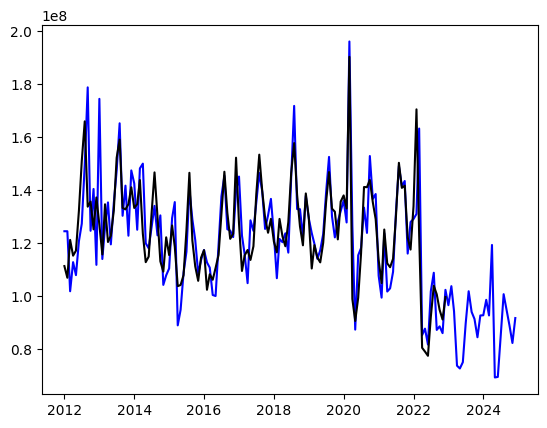

,0,1,2,T4,T3,T1,T2
Unnamed: 0.1,,,,,,,
2012-01-01,-0.217119,-0.036173,-0.037084,797013.802639,7.625436e+06,8.932217e+06,1.246100e+08
2012-02-01,-0.208866,-0.060682,0.024883,797013.802639,7.625436e+06,8.932217e+06,1.246100e+08
2012-03-01,-0.209441,-0.049079,0.000698,678457.337245,7.666458e+06,7.946131e+06,1.019559e+08
2012-04-01,-0.201517,-0.056213,-0.009327,636507.903279,8.788773e+06,8.665080e+06,1.129333e+08
2012-05-01,-0.199615,-0.042525,-0.015046,351480.237558,8.039555e+06,1.216619e+07,1.080440e+08
...,...,...,...,...,...,...,...
2024-08-01,0.212694,-0.050448,-0.024785,582104.287502,8.469183e+06,9.958037e+06,1.008510e+08
2024-09-01,0.215985,-0.052790,-0.028334,677344.476306,8.355231e+06,9.848714e+06,9.478726e+07
2024-10-01,0.221914,-0.062123,-0.013570,737842.450163,8.067618e+06,1.005870e+07,8.905668e+07


In [363]:
scores = pd.DataFrame(index=["Series", "Order", 
                               "RMSE_train", "MAPE_train", "RMSE_test", "MAPE_test" , "r2", "cross-validation sample"])

s="T2"
i=0
for cross_valid_period in [1]:
    df_uah2 = df_uah1.iloc[:int(len(df_uah1)*cross_valid_period)]
#     df_uah2 = df_uah1.iloc[:93]
    if cross_valid_period == 0.6:
        full_period = df_uah1[s].index[94]
    else:
        full_period = df_uah1[s].index[-1]


    exog = pd.DataFrame(projections,index=pd.DataFrame(projections1).index)
    exog = components
    
    

    m = SARIMAX(df_uah2[s].replace(0,df_uah2[s].mean()) , 
                            order=((0,0,0,1),1,(0,0,0,1)), 
                            seasonal_order=((1,0,1,1),1,(1,0,1,1),12), 
                            trend="c",
                exog=exog.iloc[:len(df_uah2)]).fit(disp=False)
    preds = m.predict(start = 0, end= len(projections)-1, dynamic=False, exog=exog.iloc[len(df_uah2):len(projections)+1])
    preds[0] =preds[1] 
#     preds[preds.idxmax()] = preds.mean()
    preds[preds.idxmin()] = preds.mean()
    results[s] = preds
    # try:
    mse_train = np.sqrt(mse(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]]))
    mape_train = mape(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]])
    mse_test = np.sqrt(mse(df_uah1[s].loc[df_uah1[s].index[0]:full_period],preds.loc[df_uah1[s].index[0]:full_period]))
    mape_test = mape(df_uah1[s].loc[df_uah1[s].index[0]:full_period],preds.loc[df_uah1[s].index[0]:full_period])
    r2 = r2_score(df_uah1[s].loc[df_uah1[s].index[0]:full_period],preds.loc[df_uah1[s].index[0]:full_period])
    print(mse_train, mape_train, mse_test, mape_test)
    print(preds)
    plt.plot(preds, color="blue")
    plt.plot(df_uah1[s], color="black")
#     preds.to_csv("/Users/Marta/Desktop/diploma/sarimax_pca(2).csv")
#     plt.plot(preds.conf_int)
    plt.show()
    
    scores[i] = [s, f"({p}, 1, {q})", mse_train, mape_train, mse_test, mape_test, r2, cross_valid_period]
    i += 1
# scores
results

In [364]:
results.to_csv("/Users/Marta/Desktop/diploma/results_bottom_up.csv")

Total               mean       mean_se  mean_ci_lower  mean_ci_upper
2012-02-01  2.543363e+08  2.937915e+07   2.238867e+08   2.847858e+08
2012-03-01  2.064949e+08  2.937915e+07   1.760454e+08   2.369444e+08
2012-04-01  2.285757e+08  2.937915e+07   1.981262e+08   2.590253e+08
2012-05-01  2.300486e+08  2.879099e+07   2.002087e+08   2.598886e+08
2012-06-01  2.430074e+08  2.879099e+07   2.131675e+08   2.728474e+08


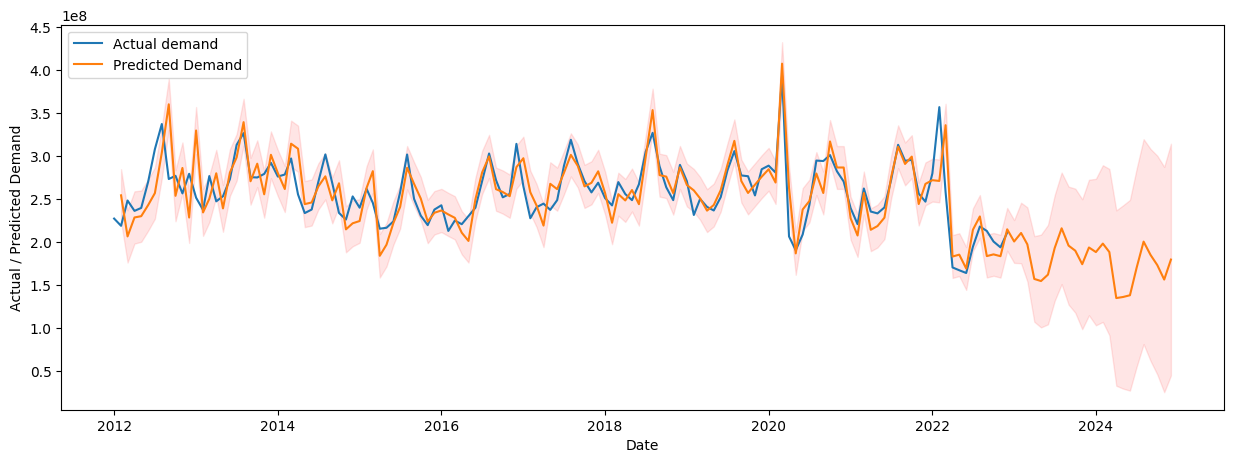

In [345]:
preds_df = (m
            .get_prediction(start=1, end=len(df_uah1)+23, exog=exog.iloc[len(df_uah1):len(df_uah1)+24+1])
            .summary_frame(alpha=0.3)
)
print(preds_df.head())
# wpi               mean   mean_se  mean_ci_lower  mean_ci_upper
# 1991-01-01  118.358860  0.725041     116.937806     119.779914
# 1991-04-01  120.340500  1.284361     117.823198     122.857802
# 1991-07-01  122.167206  1.865597     118.510703     125.823709
# 1991-10-01  123.858465  2.463735     119.029634     128.687296
# 1992-01-01  125.431312  3.070871     119.412517     131.450108

# Plot the training data, predicted means and confidence intervals
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df_uah1["Total"],label='Actual demand')
ax.set(
    xlabel='Date',
    ylabel='Actual / Predicted Demand'
)
ax.plot(preds_df['mean'], label='Predicted Demand')
ax.fill_between(
    preds_df.index, preds_df['mean_ci_lower'], preds_df['mean_ci_upper'],
    color='r', alpha=0.1
)
legend = ax.legend(loc='upper left')
plt.show()

30360134.571163252 0.09145018693011113 30360134.571163252 0.09145018693011113
2012-01-01    2.255494e+08
2012-02-01    2.255494e+08
2012-03-01    2.215161e+08
2012-04-01    2.452899e+08
2012-05-01    2.075353e+08
                  ...     
2024-08-01    3.560406e+08
2024-09-01    3.605508e+08
2024-10-01    3.752554e+08
2024-11-01    3.832578e+08
2024-12-01    3.881240e+08
Freq: MS, Name: predicted_mean, Length: 156, dtype: float64


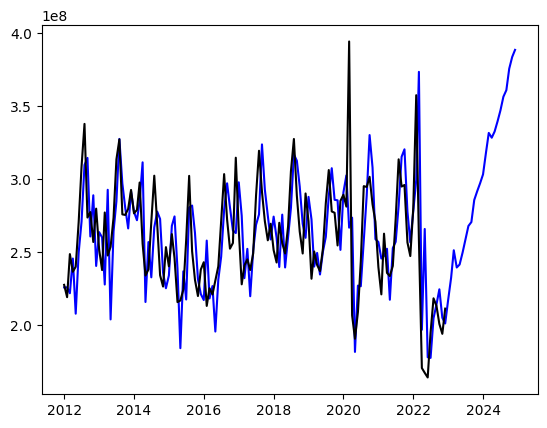

,0
Series,Total
Order,"(0, 1, 10)"
RMSE_train,3.03601e+07
MAPE_train,0.0914502
RMSE_test,3.03601e+07
MAPE_test,0.0914502
r2,0.298908
cross-validation sample,1


In [305]:
# df_uah1.iloc[60]
# df_uah1.iloc[95]
scores = pd.DataFrame(index=["Series", "Order", 
                               "RMSE_train", "MAPE_train", "RMSE_test", "MAPE_test" , "r2", "cross-validation sample"])


i=0
for cross_valid_period in [1]:
    df_uah2 = df_uah1.iloc[:int(len(df_uah1)*cross_valid_period)]
#     df_uah2 = df_uah1.iloc[:93]
    if cross_valid_period == 0.6:
        full_period = df_uah1[s].index[94]
    else:
        full_period = df_uah1[s].index[-1]


    exog = pd.DataFrame(projections,index=pd.DataFrame(projections1).index)
#     exog = components
    
    

    m = SARIMAX(df_uah2[s], 
                            order=((0,0,0,1),1,(0,0,0,1)), 
#                             seasonal_order=((1,0,1,1),1,(1,0,1,1),12), 
                            trend="c",
                exog=exog.iloc[:len(df_uah2)]).fit(disp=False)
    preds = m.predict(start = 0, end= len(projections)-1, dynamic=False, exog=exog.iloc[len(df_uah2):len(projections)+1])
    preds[0] =preds[1] 
    preds[preds.idxmax()] = preds.mean()
    preds[preds.idxmin()] = preds.mean()
    # try:
    mse_train = np.sqrt(mse(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]]))
    mape_train = mape(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]])
    mse_test = np.sqrt(mse(df_uah1[s].loc[df_uah1[s].index[0]:full_period],preds.loc[df_uah1[s].index[0]:full_period]))
    mape_test = mape(df_uah1[s].loc[df_uah1[s].index[0]:full_period],preds.loc[df_uah1[s].index[0]:full_period])
    r2 = r2_score(df_uah1[s].loc[df_uah1[s].index[0]:full_period],preds.loc[df_uah1[s].index[0]:full_period])
    print(mse_train, mape_train, mse_test, mape_test)
    print(preds)
    plt.plot(preds, color="blue")
    plt.plot(df_uah1[s], color="black")
#     plt.plot(preds.conf_int)
    plt.show()
    
    scores[i] = [s, f"({p}, 1, {q})", mse_train, mape_train, mse_test, mape_test, r2, cross_valid_period]
    i += 1
scores

In [306]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                    Total   No. Observations:                  132
Model:             SARIMAX([4], 1, [4])   Log Likelihood               -2427.725
Date:                  Sun, 14 May 2023   AIC                           4873.450
Time:                          23:45:20   BIC                           4899.326
Sample:                      01-01-2012   HQIC                          4883.965
                           - 12-01-2022                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.791e+05   4.73e-09   8.02e+13      0.000    3.79e+05    3.79e+05
0          -1.165e+08   2.56e-12  -4.55e+19      0.000   -1.17e+08   -1.17e+08
1          -4.846e+08   6.63e-12  -7.31e+19      0.000   -4.85e+08   -4.85e+08
2          -2.845e+09   3.31e-13  -8.61e+21      0.000   -2.84e+09   -2.84e+09
3          -1.288e+09   4.56e-13  -2.82e+21      0.000   -1.29e+09   -1.29e+09
4           -3.15e+09    6.4e-13  -4.92e+21      0.000   -3.15e+09   -3.15e+09
ar.L4          0.9428      0.020     47.691      0.000       0.904       0.982
ma.L4         -0.9524      0.020    -47.751      0.000      -0.991      -0.913
sigma2      7.516e+14   3.12e-18   2.41e+32      0.000    7.52e+14    7.52e+14
===================================================================================
Ljung-Box (L1) (Q):                   2.02   Jarque-Bera (JB):                12.69
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.46
Prob(H) (two-sided):                  0.77   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.59e+47. Standard errors may be unstable.
"""

In [227]:
components.isna().sum()
# import statsmodels.api as sm
# from scipy import stats
# exog.iloc[:len(df_uah2)]

0    0
1    0
dtype: int64

In [200]:

# for cross_valid_period in [0.85, 0.9, 0.95, 0.5]:
#     df_uah2 = df_uah1.iloc[:int(len(df_uah1)*cross_valid_period)]


#     exog = pd.DataFrame(projections,index=pd.DataFrame(projections1).index)
#     exog = components



df_uah2 = df_uah1.iloc[:int(len(df_uah1)*cross_valid_period)]
exog = pd.DataFrame(projections,index=pd.DataFrame(projections1).index).iloc[:len(df_uah1)]
# print(exog)
# print(len(list(df_uah1[s].shift(1).fillna(df_uah1[s].mean()))))
exog['L1'] = list(df_uah1[s].shift(1).fillna(df_uah1[s].mean()))
exog['L3'] = list(df_uah1[s].shift(2).fillna(df_uah1[s].mean()))
exog['L4'] = list(df_uah1[s].shift(3).fillna(df_uah1[s].mean()))


curr_exog = exog.iloc[:len(df_uah2)]
# print(curr_exog)
# print(len(curr_exog))
# print(len(df_uah2.shift(1).fillna(df_uah2.mean()).iloc[:len(df_uah2)]))



w = np.ones(len(df_uah2))
w[len(df_uah2) * 8 // 10 :] = 3

mod_wls = sm.WLS(df_uah2[s], curr_exog, weights=1.0 / (w ** 2))
res_wls = mod_wls.fit()
print(res_wls.summary())

mod_wls.predict()

                                 WLS Regression Results                                
Dep. Variable:                  Total   R-squared (uncentered):                   0.994
Model:                            WLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              1150.
Date:                Sun, 14 May 2023   Prob (F-statistic):                    6.29e-61
Time:                        14:45:56   Log-Likelihood:                         -1213.5
No. Observations:                  66   AIC:                                      2443.
Df Residuals:                      58   BIC:                                      2460.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

TypeError: predict() missing 1 required positional argument: 'params'

In [9]:
#  order=(12,1,3), seasonal_order=(12,1,3,16)
i = 0

for s in ['T1', 'T2', 'T3', 'T4', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16',
       'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26',
       'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36',
       'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46',
       'P47']:
    for p in p_s:
        
        for q in q_s:
            try:
                m = SARIMAX(df_uah2[s], 
                            order=(p,1,q), 
                            seasonal_order=(p,1,q,12), 
                            trend=(1, 0, 0)).fit(disp=False)
                preds = m.predict(start = 0, end= len(df_uah1), dynamic=False)
                preds[0] =preds[1]
                try:
                    mse_train = np.sqrt(mse(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]]))
                    mape_train = mape(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]])
                    mse_test = np.sqrt(mse(df_uah1[s],preds.loc[df_uah1[s].index[0]:df_uah1[s].index[-1]]))
                    mape_test = mape(df_uah1[s],preds.loc[df_uah1[s].index[0]:df_uah1[s].index[-1]])
                    print(mse_train, mape_train, mse_test, mape_test)
                except Exception as e:
                    print(e)

                scores[i] = [s, f"({p}, 1, {q})", mse_train, mape_train, mse_test, mape_test]
                i += 1
#                         print(scores)
            except Exception as e:
                print(e, "error, moving on...")

                #                     preds.plot()
#                     df_uah2["T1"].plot()
#                     df_uah1["T1"].plot()
    scores.T.to_csv(f"/Users/Marta/Desktop/diploma/SARIMAX_{s}.csv")
                    
    






1972608.034829587 0.1226825087181229 2520413.722364598 0.1586420333132542
1523354.3142992032 0.10421562325488021 1602099.0732246027 0.11170697513908717
1506010.1967022058 0.10456808972149421 1489889.2238110644 0.10148355628146295
1505153.9029249805 0.10525460751388536 1507253.1219081187 0.1026338101180942
1530953.5184446822 0.11302896961018817 1988750.799359191 0.13817670722213768
1500405.6977323312 0.10343949919765251 1598802.7038555467 0.107423736491234
1499137.9774952312 0.10212013093958554 1499479.1628894531 0.10009203957159962
1516623.2392671565 0.10484422303018492 1565004.0824531221 0.1089188201167731
1509184.8095449095 0.10623394137880908 1699089.7328060248 0.11956156033582566
1511957.5854819936 0.10628574074611927 1730205.6630591212 0.12103713432292865
1507935.3087255878 0.10629349813482117 1634166.8916040624 0.11599282605497646
1521325.7647040216 0.10730438564041025 1621675.1846328187 0.11543070712460518
1584258.471623834 0.10922285599629013 1610572.034073761 0.113172349650245

1436943.7246262436 0.09959944372134495 1546089.7554234564 0.10436760098434195
1499474.6023082528 0.10270510672200141 1507387.4124123314 0.10267436811840167
1514065.327216542 0.10494649507475187 1512702.7080647422 0.10219994378829854
1511106.4324442027 0.10463369373282005 1503743.0205223854 0.10206639486860423
1511766.696302826 0.10459066603412458 1505762.7957831293 0.1020094506881163
1434962.6141792515 0.10096216806950102 1488540.4036418253 0.10081722263998105
1452641.3163765944 0.10306454148198434 1517976.520046915 0.1032087582228631
1401480.7067700755 0.09693709596604773 1606432.6202097232 0.10835171103838499
1444206.74997142 0.10288123261956725 1504232.1050084145 0.10806701173980895
1450599.8414396634 0.0983290113933082 1486640.0965457154 0.09606007379596002
1457287.861801972 0.09851538726103312 1489470.8596588334 0.0967939921293583
1434575.4337619583 0.09682946212242917 1489946.4634138502 0.096372667910043
1430601.5631031364 0.09955620036555758 1626832.6222892685 0.1105569816371235

15768915.8883359 0.07427674420704923 18677269.645414807 0.09932278255774586
16020369.790904578 0.07518608198544473 16748178.622675378 0.08399677766129976
15758960.699304387 0.07550397175680357 17176862.882839505 0.09046164302579915
15819752.536348091 0.07574990948609964 17820007.521811515 0.09527510103278738
16151395.036445653 0.07838306762345393 17027938.932514872 0.08365487798691448
15917492.71405377 0.07532374557839626 16709576.726702826 0.08444568245472264
15720170.995268479 0.07492902521318899 16799561.093462903 0.07947072478608119
15782717.464217788 0.07457083496756434 16572803.255344644 0.08424649282987708
15866991.170530563 0.07426531581112669 16807359.38791577 0.08624706617056571
15640400.078472666 0.07329583185564446 18471863.052415144 0.09819562457455519
15521959.263318919 0.0740672793946324 19106540.289707158 0.10236854000352617
15500502.333998786 0.0747358460523929 18208063.06999865 0.09769945058599445
15478692.294206988 0.07426860882403861 17737077.882071387 0.09487317543

1416325.6795363016 0.11800071776018899 1442213.3816527613 0.11814171776491189
1468022.7279444984 0.11863198853130492 1455398.8199903402 0.1133404681921837
1420059.151728197 0.11641965322824611 1422208.8926109225 0.1116506444221969
1440434.4890182214 0.11756778699429711 1437113.457033791 0.1160848455020347
1439542.1047258747 0.1181767553914771 1475766.6929414934 0.12049847850134557
1424797.03167312 0.11891533376377504 1438656.6246116748 0.11455935511067658
1421342.5681541618 0.12164458539705635 1695458.6647341708 0.1371504406831949
1436237.8936899179 0.11889952558650409 1513938.656317775 0.11991727571176636
1376895.4282827522 0.11422644174881559 1409942.3307474682 0.11149435288403109
1374468.768341983 0.11430125207871293 1404360.0451578358 0.11100940168549096
1372481.133681042 0.1136558291871438 1394983.22463824 0.1129626533948443
1444704.1611703492 0.1184250888764768 1436724.4223895222 0.11356970673833401
1376701.1123840248 0.11484683129558146 1406033.710747364 0.1152423112011275
13870

1361561.3101084363 0.11321320682924638 1403929.6968637176 0.11426665341847703
1386496.426630439 0.11341280419374515 1420530.3926582087 0.11047094322299972
1360583.903667269 0.1098965204579604 1397741.366935752 0.10673062014236502
1353248.8277772265 0.11206111384381635 1447355.8348328427 0.11313926142196294
127405.8779712877 4.0146715002921126e+17 163284.56574966884 3.4063879396417926e+17
94578.40344967278 1.512198227234112e+18 98572.38303752776 1.283077283713792e+18
95067.69179721658 4.665325673182971e+18 179512.7364688517 3.958458146943127e+18
95394.73223656176 5.152871666027859e+18 177880.03559988283 4.3721335348115164e+18
96783.53374268886 5.863219005224246e+18 195265.77765934146 4.974852489281179e+18
92483.04748179793 1.8817069106231964e+18 109930.10985389518 1.596599802953015e+18
92806.49437211688 2.240988820107626e+18 116538.26758452864 1.9014450594852582e+18
92481.34474938625 4.460988387992131e+17 97889.9671015597 3.785081056478172e+17
92857.70413342756 9.257983796915754e+17 121

91381.58307741901 9.287995784603859e+17 94743.14231585024 7.880723696027516e+17
89749.58273242252 1.268145423425079e+18 94945.0612632682 1.0760021774515822e+18
89814.08361535295 1.5583700648857318e+18 97061.83223862492 1.3222533883878938e+18
91065.37682171416 1.9864299164922647e+18 103563.33982786161 1.6854556867207094e+18
90447.61755772866 1.395496216231866e+18 101629.00310647892 1.1840573955906742e+18
89471.3043953214 1.7050281030378788e+18 99672.15483157376 1.4466905116685033e+18
89922.56236871125 1.791737705183947e+18 110446.47624351905 1.5202622953075914e+18
89498.55805367322 2.8761185732676982e+17 126900.27210347203 2.4403430318635014e+17
89363.039437725 6.191024809516595e+16 111721.45518134284 5.2529907474686264e+16
87220.1096420274 1.0098056579574638e+17 131766.1447041587 8.568048006911814e+16
89980.62042919565 2.7579075262975184e+17 141857.5535548336 2.340042749585773e+17
91455.91137334265 1.666601902797554e+18 97674.8493344065 1.4140864629797427e+18
91335.33898793817 1.562487

2854155.437664782 0.05957150334240324 3874410.47207606 0.10353909382753944
2851050.22613455 0.05956488629119692 3821761.1379824574 0.1012522698480799
2931402.1023897063 0.059589598348393134 3077091.91776566 0.07195626662814057
2909016.4642822663 0.06205399662063655 3272763.171449 0.08777950286566376
2892422.250176219 0.0620918925480109 2850063.211082947 0.06899384670966813
2908754.9121081624 0.06280486245757924 2878222.9256027527 0.07069039287389428
2917763.392524178 0.06173870899574522 3600045.7093696236 0.09730029385306153
2934180.971999896 0.06163852222724612 3639774.408320957 0.09744746555865301
2965033.043600435 0.06267774155288854 3981150.6399892736 0.10700947518208627
2846731.382204839 0.06035444421569625 3638382.558220322 0.09837977395410352
2851478.0883362256 0.0594210759235 3689205.874399427 0.09872678129805376
2971341.1204254827 0.05979178422770738 3743325.487391372 0.09835754825401187
2838693.0448224195 0.05958941853198106 3696705.639570186 0.09924419036641126
2866332.64027

4455997.4232338285 0.17670822440486264 4736221.406791857 0.2359909917668907
4343623.4198665125 0.17238124233841728 4448677.607001688 0.21643710579578856
4343530.247940804 0.1716468830254855 4189670.7359104306 0.18731090690929844
4533543.243885468 0.1832164787438171 4365249.592369478 0.1931203938345727
4392550.738870608 0.1806445499871304 4203556.093155548 0.18670756293462887
4392719.593572503 0.18254717507002072 4456845.437370452 0.21891195541251796
4359291.526355695 0.1835065875417014 4444699.863671154 0.2178618927373994
4405758.547867205 0.181029022650447 4462209.650629586 0.21325639745117625
4648973.329768182 0.22141602358406828 5401875.892792273 0.3078679632582536
4433071.337137813 0.17939883531928347 4424902.656361863 0.20837247332412023
4695469.866111606 0.20105307996322866 5686141.338997747 0.3035962867756623
4366759.813657661 0.17262072143484322 4528644.878638384 0.21896727813249167
4339608.646924112 0.16854248653036313 4539598.740612403 0.21978500467414294
4409787.354750864 0.

4400833.065769694 0.1670124657418885 4838465.194397582 0.237273231852602
4402904.353816124 0.16779339181649608 4292217.856798677 0.18209207785657291
4410389.770437451 0.1737817737730336 4690673.10830568 0.23289419478352
4414021.50415676 0.17392699359440225 4561047.9530296335 0.22196454782385008
4404221.840210274 0.17329767923801448 4515852.582154578 0.2182341142924767
4410475.46954372 0.1730268149202597 4544080.000601425 0.21934222434138761
4420846.898956653 0.17110588115737269 4546860.358029595 0.21325373480600537
4453278.954536063 0.1692482856336308 4676750.248634043 0.2190679878971337
4428651.734495735 0.16641940580503345 4688848.638868167 0.21698595516593863
4394401.755773754 0.16563021286628704 4675971.410261387 0.2169937309792021
4440617.008230059 0.16568517258113782 4898171.347726931 0.2278692348427854
4411284.251409677 0.16875858344955766 4616579.74089909 0.21657346186628126
4405426.951515645 0.16547777267815889 4846410.453904075 0.23515530867291953
4394546.957715139 0.16517223

392851.7240307094 0.0741896884429315 459961.4005491085 0.13087282279556112
393708.734669666 0.07401114418225656 406112.0161082944 0.10734703550741129
399844.70685793256 0.07995263615703938 401074.72229821637 0.1062959888634612
397621.52057557914 0.0789545144500603 389816.6135585085 0.09874868334401625
397761.9297043122 0.07900629593498468 387885.9319624686 0.09711595687522816
395898.0837083186 0.07918309039795766 378879.28155133856 0.0875509815498524
397339.1829852842 0.07915834177283312 392386.81458667904 0.10054645698607464
390026.0253554564 0.07678546246974985 371095.90453166666 0.08505956851295272
391560.00274530525 0.07642056207654216 382005.269273408 0.09400775096573295
387400.0445691783 0.07614146816437321 409390.8028043152 0.11238028961443917
388872.0197470178 0.07343534461997663 472198.73354670085 0.13505375325284774
382183.84034130006 0.07236581952419747 468542.1439527905 0.1338516602042106
388507.6911926746 0.07344515277976095 503512.33171683445 0.1459378490809569
391948.354

243784.41798484165 0.07037956644098528 346467.2848668824 0.15649514226483333
236758.4151807045 0.06116257348849589 511002.70032540045 0.22184691638725196
236242.28216792986 0.0604369156974111 465923.0251604785 0.2020095507706858
244155.494161647 0.07253290013490322 271546.0210679014 0.11801254132535255
241192.61563973295 0.07029061338055143 265432.07493637333 0.11334210633782647
241214.7089279507 0.06981549025147933 262562.0712070938 0.1105395390870455
242338.1501535519 0.0706196564953571 287640.8713341344 0.12819518208751027
239043.69190885616 0.06850482116937455 335626.67035863013 0.15281744388258406
237880.0944177358 0.0686891997241283 296965.4270192226 0.13306845075397342
243486.98091321206 0.07178023993900497 285314.25484881515 0.12651775327916642
244259.46418524813 0.06972396195721672 311791.62927045196 0.13884770184824458
239004.9563864061 0.0671935750815145 274070.47979181644 0.11876952118737494
238624.5103996771 0.06693760670733413 392817.51273901167 0.177378274689749
235091.0

427841.51920720545 0.06273422909595913 841690.0041605926 0.09349074178167747
429735.6555334948 0.06709952222732989 785008.9237039032 0.09330171679369108
429575.3350735327 0.0670168575900381 782466.5810416839 0.093087443421269
441343.69899837126 0.06016719300477047 883006.3684598405 0.09381150603265345
436466.2050383996 0.06098403617535077 895880.2725972732 0.0950032803671795
419032.58315659815 0.05852178680301745 561674.9106225801 0.07128523097479934
418310.26016490796 0.058748872345647386 548414.7942412116 0.07052290946377822
418232.14623995556 0.05909537423747733 545653.6508736578 0.07014061274373529
417039.65792908706 0.05958036710539726 534361.8287139288 0.06920947236856456
415273.8195025282 0.059392895577573775 539354.6074407444 0.06970893143601874
417026.209759928 0.059203501385779386 545192.8202679005 0.07002427825250487
430411.4494749674 0.06462328599249569 830714.8509075352 0.09374398878717634
414310.68038391264 0.06172322490571367 847255.8200916264 0.09312572993858934
423990.

409237.6830345592 0.06395965722050076 733050.6400884972 0.08895715011841632
392111.99138914136 0.06242612886583893 549415.4655644919 0.07506383243410335
393646.5934609212 0.06352011881109647 533101.0341665624 0.073409340247011
418041.59135168843 0.06245458120896184 631855.7406461717 0.07999314292109656
408284.56944418635 0.061433783237404505 555798.1572945692 0.07197562562759674
403717.90254121483 0.060369493791297954 547363.0652474796 0.07024278805697667
405984.6236412015 0.061533134671784825 550931.6018114018 0.07111824128762223
404587.05769752845 0.06139451164293001 555355.2311158332 0.07115989927008877
408013.754556313 0.06484837216797072 548642.6347991221 0.07367378334249264
400262.50664889853 0.06268525045650587 549914.9005869967 0.07304704634376358
403404.85569223325 0.06138446914801059 749430.3213123385 0.08725722615408593
405004.34125134855 0.06363948861716584 777103.4316841888 0.09160784251965141
394466.88113089366 0.06416368102920447 793070.4025038454 0.09307779741544323
396

186707.87464788862 0.09429411368843212 182468.2627494393 0.11343739791497162
177111.02374804573 0.09233746333493405 208721.71981377192 0.15159743277474283
180307.34525026783 0.09053743208258123 252941.94671903193 0.18385131084089393
174165.3484355818 0.08569285424841744 240347.70161646418 0.17265957379863353
182481.77752216603 0.09419248130901514 183015.52617774828 0.10741177546459611
185525.6297594047 0.09520402646506125 218374.72526902254 0.1536830919323201
176013.13805770178 0.09001786854790987 223126.090727561 0.16251984012777304
175919.89650478092 0.09065968813580172 221791.24069844309 0.16239410431463666
178172.52940290756 0.09126818724037056 186885.51789252856 0.13077800312629184
180340.9475453045 0.0920197144220115 179895.39800872744 0.11815391432166808
179588.42224175303 0.09170936697760847 179280.8311134622 0.11462120417616656
179833.21720420316 0.09435669942187418 237589.10743972872 0.17569956034145925
180595.87327451733 0.09121032367616468 184189.6932442394 0.12305644929040

18434.86773630951 0.1340307558983566 17767.420843072614 0.20285090153222518
18083.254345145535 0.13117669638257054 16761.141781431328 0.141312051957702
19191.187819049042 0.14661927959992577 22209.368306199805 0.3456734683481175
18665.653405679663 0.13353475277800764 24010.668700671773 0.3761657901550723
18527.0372442186 0.13965415457018254 19609.907449754875 0.2782871477496455
19397.10512241841 0.13715189166692582 20617.421347339234 0.29220164707875645
19400.27719853709 0.13509784680273787 18667.411425349062 0.20764360615245897
19112.758631094817 0.13242012253315685 18307.80361937875 0.19819174104625983
19179.22877040484 0.1348122547906094 19639.678748891823 0.2604681777759449
19225.300007079964 0.13774235587160102 18043.004870623598 0.175087224746499
19173.926679786833 0.13517070892142108 18307.101943498918 0.19580841876510088
18756.508174843413 0.13253354335199188 17729.150824242042 0.1804573937048941
19056.617251453867 0.13603861806761636 19848.343120186833 0.2688444864166384
18211

14671.810369176734 0.24128134052347333 14719.997540002993 0.3825008988492686
15734.39742416693 0.28051855178762064 23065.982505447497 0.754200683026479
15869.918873148037 0.2621438908360966 16833.5504726358 0.42826697149575255
15148.927465132589 0.26407889400511386 30563.02321628639 0.996041319901557
13988.997564814417 0.2285063531626274 15448.146276172774 0.4517627982950331
14704.869720181945 0.2265854169878049 13774.761497653733 0.2676251013602805
14814.660159404904 0.2312401807693212 14522.616593456727 0.3441007719940557
15069.143960193145 0.24248459242911322 14781.277275239163 0.3561075187310951
14761.762110012107 0.22667106555207148 13645.852933405644 0.22234602534056264
15578.127284140215 0.2613753391193686 14740.53160996764 0.32080512172633563
15663.524144598357 0.25456931977134606 14701.000020731266 0.291637737990885
14374.487068314958 0.23407208911330743 13815.324702500982 0.31724470885812717
14288.387187730183 0.2315504272221746 15001.506636257182 0.40957199337434996
15769.97

14047.886267921314 0.21334864703908923 16808.397903404184 0.48389772760275657
13894.612474347765 0.21611062605812353 16596.818941335616 0.4782983001683232
13972.327858784076 0.2198887868448813 19891.08462289583 0.6381325821945963
13901.723777217385 0.2205805705308191 18945.027779601878 0.621232781981474
13914.609869889839 0.21373300185831434 24079.697376217857 0.8043648845185734
13810.819341053606 0.2151193560129426 16232.37063079659 0.4923430348747407
13682.939920621171 0.2160564580771472 22195.73861335134 0.675268217424492
13626.820641833703 0.21575462199005405 21889.51801290774 0.6657097863072586
13727.164484020586 0.21276604213911327 19679.20453776592 0.602068668063513
13961.3507746579 0.2154630882310112 18266.28517032573 0.5419988782341478
13910.586004929975 0.2258000754265936 27156.093676793425 0.8344340496809806
13927.084190594689 0.22313383002899143 26004.685930541524 0.8227533661734617
18691.590350425224 0.2621045042127451 21397.381850127687 0.5892736345385704
15994.0913076875

198155.1658435993 0.09634454983542613 310959.9508976964 0.18655631728769503
197188.89737131406 0.09606119414446569 295307.86708730634 0.1747456181280235
199120.67842993603 0.09612682525977366 294561.71195973095 0.17274683497590584
193882.58937308626 0.09335070737864677 357595.7081869446 0.2148664525339536
194587.85938194505 0.0940255183523665 386479.1381096343 0.2351471407361431
192400.91581929315 0.09217755738583311 295878.2265588001 0.1480041393536427
204531.28463554304 0.09748899694523049 268146.50940262474 0.13406423688895813
203345.72856315537 0.09797597325885807 261675.9491562872 0.10695525337718094
197980.94246546066 0.09612942262606063 262275.3557616996 0.120737424058495
200007.74911705247 0.09645457252065286 302617.8827393825 0.1771657696305103
195638.31126231735 0.09596102173767829 299702.2566096141 0.17848230362973114
197525.6889640879 0.09634395985284706 306246.4383456628 0.18321249032163267
198957.94631226637 0.09571899133566908 290502.6804984069 0.16720265228250702
197794

60211.76460676912 0.1683105104423491 58282.94678901788 0.19304988841918622
67941.21634558038 0.18698083323428 69452.41661571439 0.23386910993465362
58007.76037898261 0.17115177332091377 60415.61193440356 0.21295997796724447
66792.47511696974 0.19026554377863072 64691.29842956703 0.20526215093945302
66876.02600787634 0.18343563688142225 64632.67918427925 0.2002978022131389
64664.66091306182 0.17047887657938968 64312.785978899425 0.20216750759307095
61700.588333527885 0.17313124433013732 57658.98681357183 0.17321459561744348
61041.704763613016 0.17523693345415509 60514.148795591966 0.2036924373568063
60005.09629321376 0.17609567430698642 62636.987675571785 0.224083511824362
60734.61123145853 0.17482049344777476 59511.522555203366 0.20422495499149465
67744.88538736063 0.18525626406758366 66008.93740914106 0.21563489457259657
63151.449966699365 0.1874863647705987 59775.879536302426 0.19328394845854494
64857.42428529259 0.17458492162118386 63049.94331113801 0.20298235182702382
66935.0803724

33401.02389625519 0.13846610352214367 33737.512309232625 0.22795352322752546
31833.146079935133 0.13254345271925816 33127.10145069205 0.2351238622099229
33244.69472868583 0.13778181398133574 32924.96488501247 0.2131129759623579
35297.410400191824 0.14237828699707897 48871.60528801257 0.39489995728034805
35018.00371020513 0.13883298116635787 42732.35495735797 0.31978828792363057
31375.586414730515 0.13869434003506592 29791.23692211805 0.1748887618816804
31859.431593089208 0.13931663292203808 30767.95924146438 0.19244553721395263
32741.09577855046 0.14053984434237132 31185.59127445516 0.18278579710733753
33201.35519490922 0.13987595295715075 31726.3785639615 0.18644382245079927
32332.774940886015 0.13215970497773216 30717.502938702866 0.17225168335573918
32748.652921365647 0.13331931845764133 31524.591779316965 0.18602996685222944
32656.66446880258 0.13492522081386518 31709.690160846567 0.19447076674150837
32576.434046177223 0.13217171827881904 31727.242547647627 0.19358497039947872
3346

32966.23216305926 0.13121372526161934 48790.06349385851 0.3926877445533484
33122.88874073646 0.12836472397880047 51476.63883420326 0.42114848431772445
32760.087106991396 0.12777563088551017 47081.15254449413 0.37556967658079937
32687.297074417762 0.130524007260805 55073.89735986537 0.4428747667226192
32424.261719857015 0.12954314824453117 54052.78304169279 0.4344705042973046
32240.356118065054 0.13022118952705877 46258.56986708071 0.36890361015550704
32431.43667224854 0.1295011864324997 37186.53517096774 0.28464738211610596
32046.180235136395 0.1271926922698849 35687.11248513704 0.26170507925437725
31824.170847385372 0.12297689332722216 33078.284323361695 0.22095242396695183
32586.422053563605 0.12347000254263572 33520.842921121606 0.2219315392822666
31963.108711056564 0.12663383877019646 34851.72955470699 0.2504109798433617
32185.058538805653 0.12465026860098487 36494.72717631066 0.2719565133152542
32415.9958917307 0.12345264483990046 39429.2923015812 0.3046311387208319
32279.48212062

20726.80806818679 0.09796787224435148 22220.390986154893 0.14674386365137868
20837.292982317576 0.09834555010362414 25724.189801636796 0.18017181895582593
21084.403058816864 0.10196047598584508 32014.356552703197 0.2235552257324645
22363.073354887645 0.10279216751233444 41955.372807792344 0.28199592345187985
21716.30785101288 0.10162385504055835 45081.914842851875 0.3020132532293097
22555.72416390795 0.10385224240975861 22752.9418670237 0.14057880505222947
22855.46873517584 0.10409826795927533 23127.270672505932 0.1430648262408661
23145.042923721237 0.1066852791581816 23220.71770186234 0.14376115213417848
22016.38144667107 0.09985393020121278 23766.942224709168 0.15577485743213967
23587.049285838344 0.10723754910399219 23254.552107853866 0.138502750406829
23389.035518746903 0.10267219304671309 24986.43989413342 0.15737684318149522
22913.555508691235 0.09853652421223894 25615.549841155786 0.16586059283570734
20307.550143327597 0.09598745469313395 21379.760421858417 0.13951459687485218
2

46742.502891919066 0.11473194858483524 46298.1300142539 0.13436752694989226
46734.605590523424 0.1141413987551336 46369.529693856275 0.13310278032291098
46897.01658436311 0.11428441030344581 46599.13714286106 0.146042327613398
46663.10723062366 0.11537275067284557 46234.21043269509 0.132653376871196
46300.5995064203 0.1175888873192368 46046.324947117886 0.14254928915703635
50054.52646088455 0.11532739865186795 52991.19924752866 0.19848460721914388
48308.82942069094 0.11722140505969107 48211.29298333906 0.13106845238307466
48271.373917268465 0.11630965951234384 47949.649625831655 0.13534408220849398
47510.54141811334 0.11410208714316639 46848.15093890471 0.1348465586710002
46409.48696715059 0.11211521090590763 46361.00644727008 0.14197050707440798
45938.688289213234 0.11572070033538039 46225.28419876896 0.1402268471816275
46699.59729710668 0.11421170882440825 46545.830814114604 0.13058404673193333
46691.974221036944 0.1132837145425584 46507.9056054906 0.13180692305489497
46692.628436982

376187.3675325416 0.060502737398554496 459420.08108293096 0.07268972318155514
375946.50075675664 0.06028749178605165 453432.7261502396 0.07160270956602036
375729.28682286537 0.06020573682362488 445125.29885588505 0.07032518187706639
376521.687042375 0.06067213102396253 433381.23670661496 0.06876601186686819
375055.01979246276 0.06087163035454814 428392.64263480366 0.06785634433369456
390685.87129065354 0.05779260980584993 534526.4997830671 0.07752288374586769
383425.0827399844 0.06042756222468033 436196.6931469021 0.06756888012199004
382601.28441385995 0.05959583532721909 436498.1052361317 0.06695488012065973
376761.53974409186 0.0593835999598546 445285.71606033196 0.06963195888446232
378118.0492877201 0.06135985156650616 444779.32527377625 0.07067610846079701
376434.00370999734 0.05897601119011931 458050.8628725256 0.0711760554781675
374909.2527297526 0.059156425851826566 450007.4039226711 0.07015971862727888
376011.54885812366 0.06048055984829185 458681.2024182629 0.07255353326753756

370054.3200218305 0.06028268178559615 466650.88208305463 0.07327442431955734
363004.6283133045 0.06090380373419447 473569.5329819433 0.07530558975636724
368961.1225470134 0.060765395380108445 503789.03865721467 0.07726772774553092
361709.010386055 0.05893016777726116 438268.9251826727 0.06935758876936585
357711.3077004154 0.05752860136874423 423803.21015193645 0.06625518339026591
360499.0219079145 0.059681500272834635 446051.35519306 0.07071110991735842
376075.98760744435 0.05945266516759815 578690.0996062175 0.08326807411489472
373501.8778125593 0.05994026488414439 454611.92253611283 0.07142433250317043
371624.7217162533 0.05989671990875447 461030.2023552836 0.07243376514701522
370632.60571119026 0.06021371310887114 478194.2192196595 0.07481094217976682
363074.2547962895 0.056252730892691505 449651.11563406 0.06849722360114398
363877.8248820917 0.05828859923975315 441316.16689475445 0.06897871870694632
359969.9470350767 0.05828852595998272 614847.3947109877 0.08654474851568646
354147.

924656.5260535049 0.1655210054501555 1331467.0669028698 0.19656217338109236
902663.323652092 0.16338882949445793 1369011.0368834783 0.19917338402764037
894293.5643707494 0.16818967801775253 1289239.9170843135 0.19781221769542048
894634.8186824231 0.16281994854738333 1329721.8101937606 0.19585804683180003
885630.5253674608 0.15999664091369029 1286288.5359727177 0.19068209663655825
886867.4823663593 0.16452105770735184 1271345.0105789532 0.19212114053649237
936995.2197940606 0.1624188556793133 1331684.7150135473 0.1931352489371033
925803.0103293291 0.15946187048618546 1310689.314430859 0.1891647854508346
923584.2561046053 0.1573277129757759 1300503.0531661895 0.1867691814334525
914137.0219737561 0.16585462903878456 1325828.1411341187 0.19388700411479393
916450.4625171002 0.16014088914635352 1331036.572859386 0.19358719848444675
904164.7438733708 0.1638667886492895 1340759.917617779 0.19681223859190392
919850.5540936758 0.1629805508017812 1324774.4466776748 0.19330675074331982
909251.3938

3090.111699361212 0.9060768913008003 3124.93986134048 6.57319774309585e+17
3097.0427882154418 0.6285755650864304 3106.2129275776324 6.449461065547245e+17
3053.3554177470896 0.34894148977185846 3057.5439192019376 6.106628294565952e+17
3085.7950116496804 0.36480241256022056 3152.0464938165546 7.028984310982854e+17
3071.909214139993 0.49536192682354363 3124.5227475587903 7.01651935974712e+17
3121.6308618816706 0.47207604911549705 2977.0351229696757 3.702595329969547e+17
3135.340843453134 0.5218641547335305 2909.2249354967526 6.4369585814012504e+16
3234.100276081922 0.6444129828768059 3042.35136553643 2.4244479623608723e+17
3157.5734523913798 0.7510491907715969 3163.3211971262394 6.135772454362212e+17
3088.6677185276944 0.6812676952176757 3032.47643768292 5.270853765266705e+17
3168.2591291320414 0.5679119702265837 2983.1599434379955 2.304684596326349e+17
3078.558568049206 0.722275114095918 3113.98620342879 6.78482978330888e+17
3086.920985108989 0.6489697330897405 3105.5756581565342 6.43492

1961582.3910859001 0.07264128576296645 2129720.6883104923 0.09700879083290022
1959705.9507514548 0.07275715346136305 2040893.1612075283 0.09093480661475294
1949013.5890682773 0.07254014813623426 1927438.4007853908 0.07965561122696915
1932087.1986864193 0.07249898273672307 1929348.1052792007 0.07917225105136344
1962099.3757714091 0.07293850945551894 2023465.5938027636 0.08932763088239322
1989436.8430412586 0.07369772494188283 2014295.4793380399 0.08705700239665455
1984548.5586320583 0.0746216784015477 1998240.050282448 0.08107682657760117
1987144.9090021432 0.07460989791522332 2006273.5999217916 0.08154671301577679
2033561.6048504678 0.07560392460743746 2041977.5968432087 0.08145173655267615
2011937.547516593 0.0787202617872342 1987261.478110697 0.08688374855873386
1946944.962171568 0.07689681339280527 1948835.1521422567 0.08242446328436016
1956061.8706812162 0.07378364294273294 2127570.9839118286 0.09818236977238665
1949493.7285929085 0.07284226685380059 1949718.459397056 0.07992279801

KeyboardInterrupt: 

In [315]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pd.DataFrame(pca.fit_transform(projections), index=pd.DataFrame(projections1).index)

In [9]:
scores.T.to_csv("/Users/Marta/Desktop/diploma/SARIMAX_full_3.csv")


In [3]:
scores2 = pd.DataFrame(columns=["Series", "Trend", "Model_type", "Order", 
                               "RMSE_train", "MAPE_train", "RMSE_test", "MAPE_test"])
p_s = range(0, 12)
q_s = range(0, 12)

In [ ]:
i = 0

for s in ["T1", "T2", "Total 1"]:
    for t in ["c", (1, 0, 0)]:
        for model_type in ["additive", "multiplicative"]:
            for p in p_s:
                for q in q_s:
                    for p_seas in p_s:
                        for q_seas in q_s:
                            try:
                                m = SARIMAX(df_uah2[s], 
                                            order=(p,1,q), 
                                            seasonal_order=(p_seas,1,q_seas,12), 
                                            type=model_type, 
                                            trend=t).fit(disp=False)
                                preds = m.predict(start = 0, end= 67, dynamic=False)
                                preds[0] =preds[1]
                                try:
                                    mse_train = np.sqrt(mse(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]]))
                                    mape_train = mape(df_uah2[s],preds.loc[df_uah2[s].index[0]:df_uah2[s].index[-1]])
                                    mse_test = np.sqrt(mse(df_uah1[s],preds.loc[df_uah1[s].index[0]:df_uah1[s].index[-1]]))
                                    mape_test = mape(df_uah1[s],preds.loc[df_uah1[s].index[0]:df_uah1[s].index[-1]])
                                    print(mse_train, mape_train, mse_test, mape_test)
                                except:
#                                     print(list(preds))
                                    print("ERROR")

                                scores2.at[i, :] = [s, t, model_type, f"({p}, 1, {q}), S({p_seas}, 1, {q_seas})", mse_train, mape_train, mse_test, mape_test]
                                i += 1
                            except:
                                print("error, moving on...")

ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...
ERROR
error, moving on...


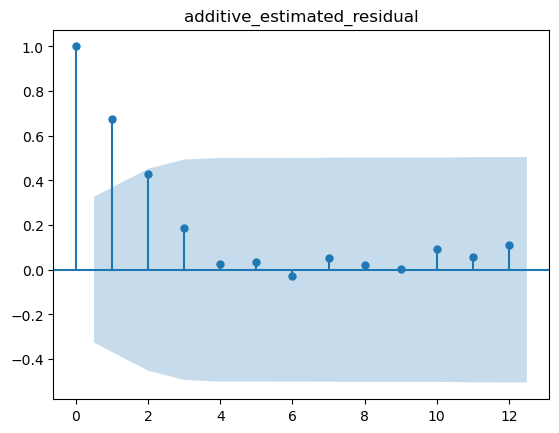

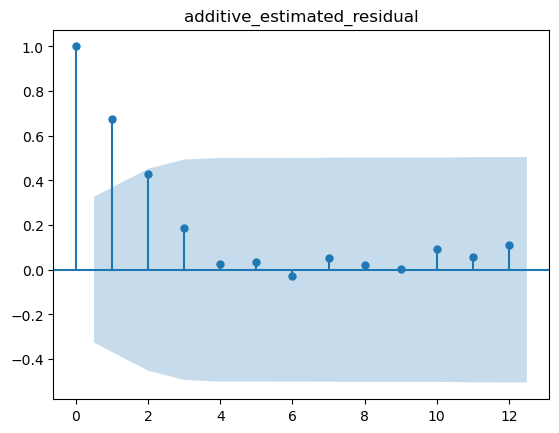

In [55]:
plot_acf(df_uah2["T1"].dropna(), lags=12, title="additive_estimated_residual")